In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from utils import *

W0905 21:51:21.466670 4380702144 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



*Point estimates* in Bayesian inference are computed using expected values. In more analytical Bayesian inference, we would have been required to evaluate complicated expected values represented as multi-dimensional integrals. No longer. If we can sample from the posterior distribution directly, we simply need to evaluate averages. If accuracy is a priority, plots like the ones above show how fast you are converging. And if further accuracy is desired, just take more samples from the posterior.

In [18]:
reset_sess()

import wget
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter4_TheGreatestTheoremNeverTold/data/census_data.csv'
filename = wget.download(url)
filename

'census_data.csv'

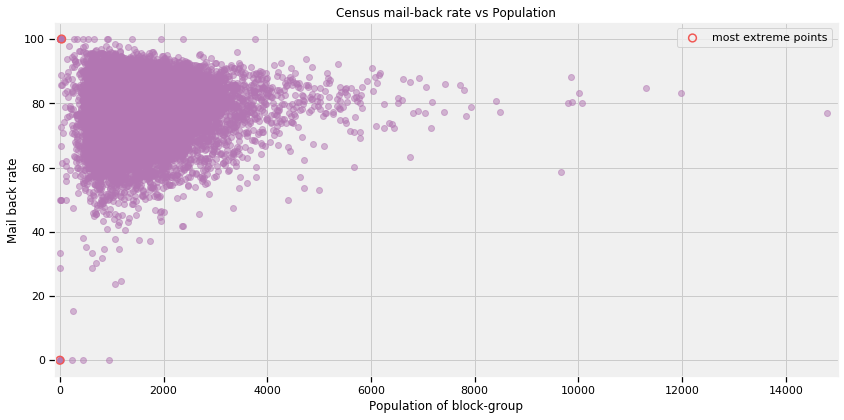

In [19]:
plt.figure(figsize(12.5, 6.5))
data_ = np.genfromtxt('census_data.csv', skip_header=1, delimiter=",")
plt.scatter(data_[:, 1], data_[:, 0], alpha=0.5, c=TFColor[6])
plt.title('Census mail-back rate vs Population')
plt.ylabel('Mail back rate')
plt.xlabel('Population of block-group')
plt.xlim(-100, 15e3)
plt.ylim(-5, 105)

i_min = tf.argmin(data_[:, 0])
i_max = tf.argmax(data_[:, 0])

[ i_min_, i_max_ ] = evaluate([ i_min, i_max])

plt.scatter([data_[i_min_, 1], data_[i_max_, 1]],
            [data_[i_min_, 0], data_[i_max_, 0]],
            s=60, marker='o', facecolors='none',
            edgecolors=TFColor[0], linewidth=1.5,
            label='most extreme points')
plt.legend(scatterpoints=1);

In [24]:
import sys
import numpy as np
from IPython.core.display import Image
import praw

reset_sess()

enter_client_id = 'QuI735zCiqD0Lw'
enter_client_secret = 'tLhqxrlLpFhbY4sFpnskjY3Gx4c'
enter_user_agent = 'Bayesian'
enter_username = 'StoicalOptimist'
enter_password = 'ErYueMi2@!'

reddit = praw.Reddit(client_id=enter_client_id, \
                     client_secret=enter_client_secret, \
                     user_agent=enter_user_agent, \
                     username=enter_username, \
                     password=enter_password)

subreddit_name = 'showerthoughts'
subreddit = reddit.subreddit(subreddit_name)

# Go by timespan - 'hour', 'day', 'week', 'month', 'year', 'all'
# Might need to go longer than an hour to get entries..
timespan = 'day'

top_submissions = subreddit.top(timespan)

# Adding a number to the inside of int() call will get the ith top post
ith_top_post = 2
n_sub = int(ith_top_post)

i = 0
while i < n_sub:
    top_submission = next(top_submissions)
    i += 1
    
top_post = top_submission.title

upvotes = []
downvotes = []
contents = []

for sub in top_submissions:
    try:
        ratio = sub.upvote_ratio
        ups = int(round((ratio*sub.score)/(2*ratio - 1))
                  if ratio != 0.5 else round(sub.score / 2))
        upvotes.append(ups)
        downvotes.append(ups - sub.score)
        contents.append(sub.title)
    except Exception as e:
        continue

votes = np.array([upvotes, downvotes]).T

print('Post contents: \n')
print(top_post)

Post contents: 

In 500 years a young archeologist is going to find someones preserved sketch book with crazy monsters, dark horror beings and evil Garfield sketches and spend his whole career trying to prove their existence.


In [25]:
"""
Contents: an array of the text from the last top submissions to a subreddit
votes: a 2d numpy array of upvotes, downvotes for each submission.
"""
n_submissions_ = len(votes)
submissions = tfd.Uniform(low=float(0.), high=float(n_submissions_)).sample(sample_shape=(4))
submissions_ = evaluate(tf.to_int32(submissions))

print('Submissions (out of %d total) \n----------------'%n_submissions_)
for i in submissions_:
    print('"' + contents[i] + '"')
    print('upvotes/downvotes: ', votes[i,:], '\n')

W0824 13:00:18.774566 4507588032 deprecation.py:323] From <ipython-input-25-27a459a2ece7>:7: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Submissions (out of 98 total) 
----------------
"Homeless people's dogs might not realize they are homeless, but just on a really long walk"
upvotes/downvotes:  [116   9] 

"As you get older, writing your signature becomes a much higher percentage of your total handwriting overall."
upvotes/downvotes:  [72  1] 

"Never stick anything up your asshole without first having a gameplan for getting it out."
upvotes/downvotes:  [79  4] 

"Newer generations won't know the joy of saving your phone from hitting the ground because you grabbed your headphone cord."
upvotes/downvotes:  [1851   57] 



For a given true upvote ratio $p$ and $N$ votes, the number of upvotes will look like a Binomial random variable with parameters $p$ and $N$. (This is because the equivalence between upvote ratio and probability of upvoting versus downvoting, out of $N$ possible votes/trials). We create a function that performs Bayesian inference on $p$, for a particular submissions' upvote/downvote pair.

In [26]:
def joint_log_prob(upvotes, N, test_upvote_ratio):
    tfd = tfp.distributions
    
    rv_upvote_ratio = tfd.Uniform(name="upvote_ratio", low=0., high=1.)
    rv_observations = tfd.Binomial(name="obs",
                                   total_count=float(N),
                                   probs=test_upvote_ratio)
    
    return (
        rv_upvote_ratio.log_prob(test_upvote_ratio)
        + tf.reduce_sum(rv_observations.log_prob(float(upvotes)))
    )

In some cases we might want to run something like an HMC for multiple, or a variable number of inputs. Loops are common examples of this. Here we define our function for setting up an HMC that can take in different numbers of upvotes and/or downvotes.

In [38]:
def posterior_upvote_ratio(upvotes, downvotes):
    reset_sess()
    
    burnin=1000
    
    N = float(upvotes) + float(downvotes)
    
    # Initialize the step size. (It will be automatically adapted)
    with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
        step_size = tf.get_variable(
            name='step_size',
            initializer=tf.constant(0.5, dtype=tf.float32),
            trainable=False,
            use_resource=True
        )
        
    # Set the chain's start state.
    initial_chain_state = [
        0.5 * tf.ones([], dtype=tf.float32, name='init_upvote_ratio')
    ]
    
    # Since HMC operates over unconstrained space, we need to transform the
    # samples so they live in real space.
    unconstrained_bijectors = [
        tfp.bijectors.Sigmoid()
    ]
    
    # Define a closure over our joint_log_prob.
    unnormalized_posterior_log_prob = lambda *args: joint_log_prob(upvotes, N, *args)
    
    # Define the HMC
    hmc = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            num_leapfrog_steps=2,
            step_size=step_size,
            step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
                num_adaptation_steps=int(burnin * 0.8)),
            state_gradients_are_stopped=True),
        bijector=unconstrained_bijectors)
    
    # Sample from the chain.
    [
        posterior_upvote_ratio
    ], kernel_results = tfp.mcmc.sample_chain(
        num_results=20000,
        num_burnin_steps=5000,
        current_state=initial_chain_state,
        kernel=hmc)
    
    # Initialize any created variables.
    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    
    evaluate(init_g)
    evaluate(init_l)
    
    return evaluate([
        posterior_upvote_ratio,
        kernel_results,
    ])

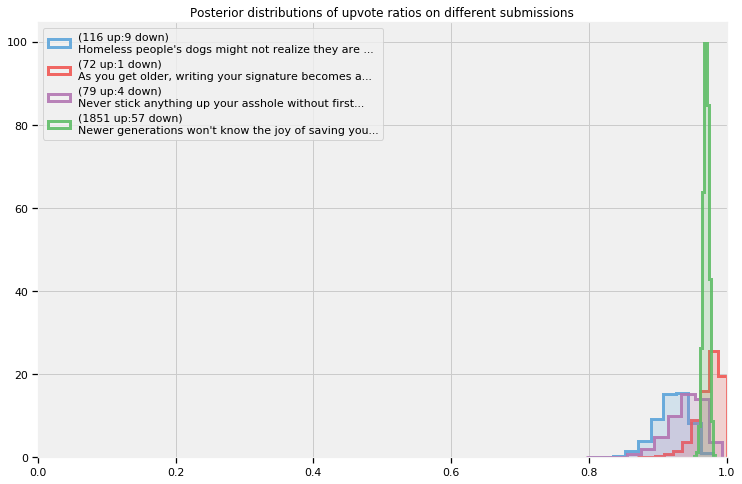

In [40]:
plt.figure(figsize=(11., 8.))
posteriors = []
colours = ["#5DA5DA", "#F15854", "#B276B2", "#60BD68", "#F17CB0"]
for i in range(len(submissions_)):
    j = submissions_[i]
    posteriors.append( posterior_upvote_ratio(votes[j, 0], votes[j, 1])[0])
    plt.hist( posteriors[i], bins=10, normed=True, alpha=.9,
            histtype="step", color=colours[i], lw=3,
            label='(%d up:%d down)\n%s...'%(votes[j, 0], votes[j, 1], contents[j][:50]))
    plt.hist(posteriors[i], bins=10, normed=True, alpha=.2,
            histtype='stepfilled', color=colours[i], lw=3,)
    
plt.legend(loc='upper left')
plt.xlim(0, 1)
plt.title('Posterior distributions of upvote ratios on different submissions');

### Sorting!

We have been ignoring the goal of this exercise: how do we sort the submissions from *best* to *worst*? Of course, we can't sort distributions, we must sort scalar numbers. There are many ways to distill a distribution down to a scalar: expressing the distribution through its expected value, or mean is one way. Choosing the mean is a bad choice though. This is because the mean doesn't take into account the uncertainty of distributions.

I suggest using the 95% *least plausible value*, defined as the value such that there is only a 5% chance the true parameter is lower (think of the lower bound on the 95% credible region). Below are the posterior distributions with the 95% least-plausible value plotted:

[3 1 2 0] [0.87697566, 0.93913263, 0.8920068, 0.96302664]


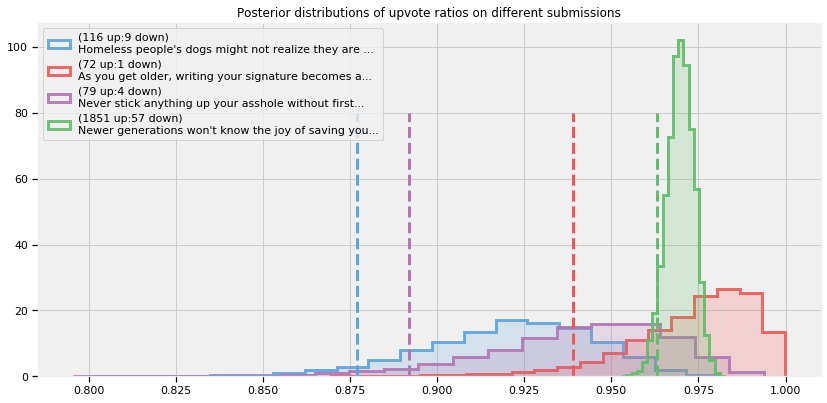

In [42]:
N = posteriors[0].shape[0]
lower_limits = []

for i in range(len(submissions_)):
    j = submissions_[i]
    plt.hist( posteriors[i], bins=20, normed=True, alpha=.9,
            histtype='step', color=colours[i], lw=3,
            label = '(%d up:%d down)\n%s...'%(votes[j, 0], votes[j, 1], contents[j][:50]))
    plt.hist(posteriors[i], bins=20, normed=True, alpha=.2,
            histtype='stepfilled', color=colours[i], lw=3,)
    v = np.sort(posteriors[i])[int(0.05*N)]
    plt.vlines(v, 0, 80, color=colours[i], linestyles='--', linewidths=3)
    lower_limits.append(v)
    plt.legend(loc='upper left')
    
plt.legend(loc='upper left')
plt.title('Posterior distributions of upvote ratios on different submissions');
order = np.argsort(-np.array(lower_limits))
print(order, lower_limits)

The best submissions, according to our procedure, are the submissions that are *most-likely* to score a high percentage of upvotes. Visually those are the submissions with the 95% least plausible value close to 1.

Why is sorting based on this quantity a good idea? By ordering by the 95% least plausible value, we are being the most conservative with what we think is best. When using the lower-bound of the 95% credible interval, we believe with high certainty that the 'true upvote ratio' is at the very least equal to this value (or greater), thereby ensuring that the best submissions are still on top. Under this ordering, we impose the following very natural properties:

1. Given two submissions with the same observed upvote ratio, we will assign the submission with more votes as better (since we are more confident it has a higher ratio).
2. Given two submissions with the same number of votes, we still assign the submission with more upvotes as *better*.

### But this is too slow for real-time!
Computing the posterior of every submission takes a long time, and by the time you have computed it, likely the data has changed. The following formula will compute the lower bound very fast.

$$
\frac{a}{a+b}-1.65\sqrt{\frac{ab}{(a+b)^2(a+b+1)}}
$$
where
$$
\begin{aligned}
a & = 1 + u\\
b & = 1 + d\\
\end{aligned}
$$
$u$ is the number of upvotes, and $d$ is the number of downvotes. The formula is a shortcut in Bayesian inference, which will be further explained.

In [44]:
def intervals(u, d):
    a = tf.add(1., u)
    b = tf.add(1., d)
    mu = tf.divide(x=a, y=tf.add(1., u))
    std_err = 1.65 * tf.sqrt((a * b) / ((a + b) ** 2 * (a + b + 1.)))
    return (mu, std_err)

print('Approximate lower bounds:')
posterior_mean, std_err = evaluate(intervals(votes[:, 0], votes[:, 1]))
lb = posterior_mean - std_err
print(lb)
print('\n')
print('Top 40 sorted according to approximate lower bounds:')
print('\n')
[ order ] = evaluate([tf.nn.top_k(lb, k=lb.shape[0], sorted=True)])
ordered_contents = []
for i, N in enumerate(order.values[:40]):
    ordered_contents.append(contents[i])
    print(votes[i, 0], votes[i, 1], contents[i])
    print('----------------')

Approximate lower bounds:
[0.99811584 0.99735886 0.9948837  0.99634576 0.9950218  0.99421793
 0.99329484 0.9902927  0.9931149  0.9935233  0.99126726 0.9875258
 0.9904354  0.98773515 0.9857438  0.9870747  0.97861946 0.98535305
 0.9833235  0.9728201  0.9797614  0.9739287  0.9809894  0.9811272
 0.98033845 0.97493166 0.9756544  0.98006433 0.97786295 0.98068434
 0.97959495 0.96627873 0.967664   0.96753293 0.9646741  0.9686038
 0.97397137 0.9605303  0.9793161  0.9571861  0.96347225 0.969434
 0.9778608  0.96562505 0.96101296 0.97073865 0.9671971  0.97216624
 0.97471726 0.9682203  0.9796439  0.9687408  0.9667713  0.97171575
 0.96143353 0.9607203  0.95052576 0.9478798  0.9502786  0.9631623
 0.9695076  0.9581355  0.9556221  0.94643366 0.9544273  0.95053595
 0.9488015  0.94757634 0.9545303  0.9399486  0.9488718  0.9539136
 0.9361735  0.94299465 0.953262   0.9365571  0.94205    0.94339633
 0.9516215  0.9368613  0.9311178  0.92569053 0.93518186 0.93126136
 0.9387111  0.92474455 0.9268551  0.9340053

We can view the ordering visually by plotting the posterior mean and bounds, and sorting by the lower bound. In the plot below, notice that the left error bar is sorted (as we suggested this is the best way to determine an ordering), so the means, indicated by dots, do not follow any strong pattern.

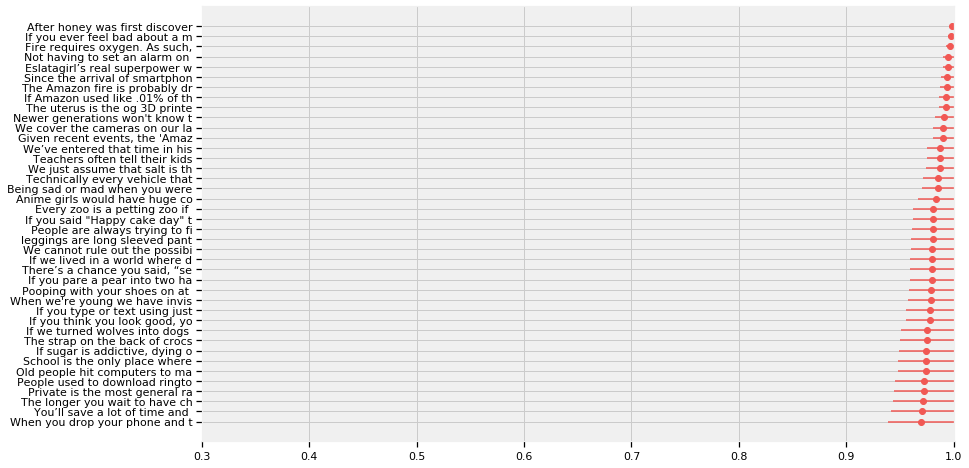

In [46]:
r_order = order.indices[::-1][-40:]
ratio_range_ = evaluate(tf.range(len(r_order)-1, -1, -1))
r_order_vals = order.values[::-1][-40:]
plt.figure(figsize=(12, 8))
plt.errorbar(r_order_vals, np.arange(len(r_order)),
            xerr=std_err[r_order], capsize=0, fmt='o',
            color=TFColor[0])

plt.xlim(0.3, 1)
plt.yticks(ratio_range_, map(lambda x: x[:30].replace('\n',''), ordered_contents));

### Extension to starred rating systems

We can consider the upvote-downvote problem above as binary: 0 is a downvote, 1 if an upvote. a $N$-start rating system can be seen as a more continuous version of the above, and we can set $n$ stars rewarded is equivalent to rewarding $\frac{n}{N}$. For example, in a 5-start system, a 2 star rating corresponds to 0.4. A perfect rating is a 1. We can use the same formula as before, but with $a$, $b$ defined differently:

$$
\frac{a}{a+b}-1.65\sqrt{\frac{ab}{(a+b)^2(a+b+1)}}
$$

where

$$
\begin{aligned}
a & = 1 + S\\
b & = 1 + N - S\\
\end{aligned}
$$
where $N$ is the number of users who rated, and $S$ is the sum of all the ratings, under the equivalence scheme mentioned above.

### Example: Counting Github stars
What is the average number of stars a Github repository has? How would you calculate this? There are over 6 million repositories, so there is more than enough data to invoke the Law of Large numbers. Let's start pulling some data.

In [4]:
reset_sess()

import wget
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter3_MCMC/data/github_data.csv'
filename = wget.download(url)
filename

'github_data.csv'

In [ ]:
from json import loads
import datetime
import numpy as np
from requests import get

"""
variables of interest:
    indp. variables
    - language, given as a binary variable. Need 4 positions for 5 languages
    - # number of days created ago, 1 position
    - has wiki? Boolean, 1 position
    - followers, 1 position
    - following, 1 position
    - constant
    
    dep. variables
    - stars/watchers
    - forks
"""

MAX = 8000000
today = datetime.datetime.today()
randint = np.random.randint
N = 120
auth = ('username', 'password')


In [49]:
import pandas as pd

In [50]:
df = pd.read_csv('github_data.csv')

In [51]:
df.head()

,Python,Javascript,Ruby,Java,Shell,PHP,days_since_creation,has_wiki,author_following,author_followers,starred_count,forked_count
0,0,1,0,0,0,0,523,1,0,0,2,1
1,0,1,0,0,0,0,778,1,193,95,1,0
2,0,0,0,1,0,0,531,1,1,4,3,0
3,0,0,1,0,0,0,396,1,1,2,2,0
4,0,0,0,0,1,0,846,1,3,5,1,0
